# Data Engineer Technical Assessment 
### Saad Shahid
### 2nd June, 2020

Time distribution
**Task 1**: 45 min
**Task 2**: 15 min
**Task 3**: 20 min


#### Programming Task

In [19]:
#import statements
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [20]:
#read areas and visits files into dataframes
areas=pd.read_csv('areas.csv')
visits=pd.read_csv('visits.csv')


In [21]:
user_file = open("users.txt", "r")
users={}

#read users into a dictionary with beneficiary being the key and value being the user id
for line in user_file:
    k,v=line.split(": ")
    for beneficiary in v.split(','):
        users[beneficiary[12:]]=k[5:]
    

In [22]:
#Count visits for each beneficiary
visit_count=Counter([beneficiary[12:] for beneficiary in visits['Beneficiary'].tolist()])
#mean of all visits
visit_mean=np.array(list(visit_count.values())).mean()
print(visit_mean)
#median of all visis
visit_median=np.median(list(visit_count.values()))
print(visit_median)

#filter out beneficiaries that have received less than the median amount of healthcare
insufficient=[k for k,v in visit_count.items() if v < visit_median]

5.074385964912281
5.0


In [23]:
#Make a dictionary with key as the beneficiary and value as the district of that beneficiary
area_dict=dict(zip([b[12:] for b in areas['Beneficiary'].tolist()],[d[9:] for d in areas['Area'].tolist()]))

#Count the number of beneficiaries in each district with less than median number of visits
area_count=Counter([v for k,v in area_dict.items() if k in insufficient])
    

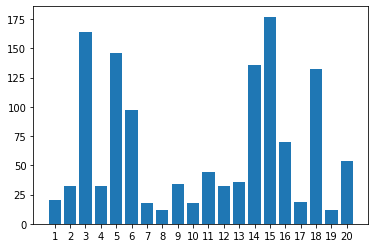

In [24]:
#Function to plot bar graph
def plot_bar(d):
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()))
    plt.show()
    
#the district number against the number of beneficiaries in each dictrict with 'insufficient' health care visits   
plot_bar(area_count)

There are some beneficiaries in the visit data which are not assigned to any user. We'll remove those for this analysis

In [25]:
#These are the number of beneficiaries which are not assigned to any users
not_assigned=[v for v in visit_count if v not in users.keys()]
len(not_assigned)
#remove from visit_count to keep user data consistent
visit_count={k:v for k,v in visit_count.items() if k in users.keys()}
len(visit_count)

2823

In [26]:
user_visits=Counter(set(users.values()))
for k,v in visit_count.items(): 
    user_visits[users[k]]+=1
user_median=np.median(list(user_visits.values()))
print(user_median)

98.0


The median number of visits for health care users is 98. We can identify the the underperformers and overperformers by looking at the users which are significantly less or more than the median value. Another way of doing this would be to look at the IQR and see the outliers.
The visualization below can be improved given more time. Since this is a time bound activity I am using the basic bar chart without formatting.

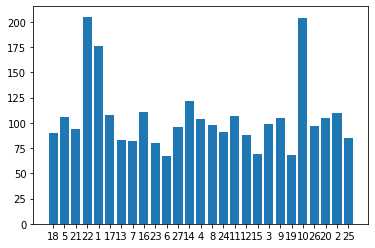

In [27]:
#Plot user against number of visits
plot_bar(user_visits)

Some of the possible explanations for the results we see:
    1. The users who are underperforming might not be getting as many calls/visits from beneficiaries. This might a case of need
    2. The districts where more beneficiaries are present that are not receiving sufficient healthcare might not have enough users assigned to them. 
    3. Districits with less visits might not have enough clinics
Some of the explanations above can be checked/validated from the data given. We could check users assigned to each district for example.

#### Code Review Task

Please note I do not have much experience with R. My primary languages are Java and Python. I have also not used
the pipe function in R before as used here (Had to google). 
Suggestions:
1. Also add a condition to check if beneficiary 1 is in program B and beneficiary 2 is in program A. Right now by restricting 
beneficiary 1 to program A we are limiting the number of potential candidates.
2. Filter by area first and then program. Filtering by area twice after doing it by program is unneccessary.
3. Overlap should be measured as total similar biometrics/ sum of total beneficiaries from both programs. The metric should not be influenced by lack of data.
If we do not have a comparison of two beneficiaries, that should negatively influence the value of our metric. (encourage more data collection/ data building)
4. Remove/Comment out the print statements. This is unneccessary output. The function should just return the required metric.
5. We should keep the threshold as an input parameter rather than hardcode it to 80. Thats a better practice in case decision makers decide to change that
treshold.


#### Design Task

From the top of my head a good visualization to show in the app would be to show a heat map. The darker an area is on a map, the higher the number of programs which cover those areas. We can also provide two dropdown menus to the user where they can use two programs to compare and we can show the stats of the overlapping beneficiaries. The stats would obviously be aggregated and would show demographic information available of the overlaps.

**Here is how I think we can arrange the data**:
We build a new database table (lets call it beneficiary_program) with a unique id assigned to each beneficiary and then a binary column (1/0) for each program. build this table by comparing beneficiaries in the same area with same gender and same age. Filtering through demographics significantly reduces the number of comparisons we need to make (number of API calls). This is a one time exercise that we do for all our existing data before taking the application live. 

**Once the application is live**:
Considering the nature of the application, I do not believe the picture on the app needs to be updated live. We can run a batch script (frequency dependent on number of entries we get in a given time period). The batch script takes in new entries in the database since the last run, filters based on gender, area and age and compares with the existing entries in our beneficiary program (filtered). If it exists we simply set the column of the program in the new entry to 1. 

**Backend of the visualization**: 
We can make aggregated tables for the visualization which can be refreshed after a certain time. For example if the app is on Microstrategy Mobile platform we would set up a cube that is refreshed with a frequency we deem appropriate. For the heat map we can simply mantain a table with area and number of programs it has which is built from the beneficiary_program table. For the comparisons depending on the size of the data we can either do an instant query or have a table with an entry for all possible comparisons (this would again be updated every x time period from our refresh scripts)